<a href="https://colab.research.google.com/github/robert-myers/you-had-me-at-hello/blob/master/notebooks/memorable_movie_quotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install catboost

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
import re
import random
import dill as pickle
import itertools

from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.metrics import edit_distance
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score, silhouette_samples
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans, MeanShift, MiniBatchKMeans
from sklearn.preprocessing import FunctionTransformer
from catboost import CatBoostClassifier

from scipy.spatial import distance

from google.colab import files

plt.style.use("seaborn")

In [5]:
nltk.download(['stopwords', 'wordnet', 'punkt', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
colab = True
if colab:
  df = pd.read_csv("https://raw.githubusercontent.com/robert-myers/you-had-me-at-hello/master/data/memorable_nonmemorable_movie_quotes_df.csv", index_col="line_id")
else:
  df = pd.read_csv("../data/memorable_nonmemorable_movie_quotes_df.csv", index_col="line_id")

In [7]:
 df[df["movie_title"].str.contains("matrix")]

,movie_title,line,levenshtein_distance_from_script,memorable?
line_id,,,,
516011,the matrix,"Tell me, Mr. Anderson, what good is a phone ca...",9,1
516533,the matrix,"But I believe that, as a species, human beings...",0,0
516175,the matrix,Welcome to the desert of the real.,13,1
516174,the matrix,This is Chicago as it exists today.,0,0
516583,the matrix,Find them and destroy them,1,1
516570,the matrix,"Can you hear me, Morpheus?",0,0
516001,the matrix,"I'm going to enjoy watching you die, Mr. Ander...",60,1
516573,the matrix,"I must get out of here, I must get free.",0,0
516505,the matrix,Never send a human to do a machine's job.,0,1


In [0]:
tokenizer = PunktSentenceTokenizer(" ".join(df["line"]))

stop_words = set(stopwords.words("english"))

def rm_stop_and_tokenize(x, join=True, remove_stop=False):
  x = re.sub('\W+', ' ', x)
  wnl = WordNetLemmatizer()
  if remove_stop:
    string = " ".join([wnl.lemmatize(word).lower() for word in x.split() if word.lower() not in stop_words])
  else:
    string = " ".join([wnl.lemmatize(word).lower() for word in x.split()])
  tokens = word_tokenize(string)
  if join:
    return " ".join(tokens)
  return tokens

df["tokenized"] = df["line"].apply(lambda x: rm_stop_and_tokenize(x, join=True, remove_stop=False))

In [0]:
df["parts_of_speech"] = df["line"].apply(lambda x: [tup[-1] for tup in nltk.pos_tag(x.split())])

In [10]:
df[df["movie_title"].str.contains("matrix")]

,movie_title,line,levenshtein_distance_from_script,memorable?,tokenized,parts_of_speech
line_id,,,,,,
516011,the matrix,"Tell me, Mr. Anderson, what good is a phone ca...",9,1,tell me mr anderson what good is a phone call ...,"[NNP, VBZ, NNP, NNP, WP, NN, VBZ, DT, NN, NN, ..."
516533,the matrix,"But I believe that, as a species, human beings...",0,0,but i believe that a a specie human being defi...,"[CC, PRP, VBP, RB, IN, DT, JJ, JJ, NNS, VBP, P..."
516175,the matrix,Welcome to the desert of the real.,13,1,welcome to the desert of the real,"[VB, TO, DT, NN, IN, DT, NN]"
516174,the matrix,This is Chicago as it exists today.,0,0,this is chicago a it exists today,"[DT, VBZ, NNP, IN, PRP, VBZ, NN]"
516583,the matrix,Find them and destroy them,1,1,find them and destroy them,"[VB, PRP, CC, VB, PRP]"
516570,the matrix,"Can you hear me, Morpheus?",0,0,can you hear me morpheus,"[MD, PRP, VB, NNS, NNP]"
516001,the matrix,"I'm going to enjoy watching you die, Mr. Ander...",60,1,i m going to enjoy watching you die mr anderson,"[NNP, VBG, TO, VB, VBG, PRP, VBP, NNP, NNP]"
516573,the matrix,"I must get out of here, I must get free.",0,0,i must get out of here i must get free,"[PRP, MD, VB, IN, IN, NN, PRP, MD, VB, NN]"
516505,the matrix,Never send a human to do a machine's job.,0,1,never send a human to do a machine s job,"[RB, VB, DT, NN, TO, VB, DT, NN, NN]"


In [11]:
df.loc[364691]["line"]

'All we want is to be treated like human beings, not like guinea pigs to be experimented on and not like bunny rabbits to be patronized.'

In [12]:
memorable_tokens = df[df["memorable?"] == 1]["tokenized"]
memorable_counter = Counter((" ".join(memorable_tokens)).split())
non_memorable_tokens = df[df["memorable?"] == 0]["tokenized"]
non_memorable_counter = Counter((" ".join(non_memorable_tokens)).split())

print(" memorable", " |",  "non-memorable")
print("----------------------------")
for x,y in zip(memorable_counter.most_common(25), non_memorable_counter.most_common(25)):
  print(x, "|", y)

 memorable  | non-memorable
----------------------------
('you', 958) | ('i', 933)
('i', 864) | ('you', 850)
('the', 745) | ('the', 728)
('a', 728) | ('to', 641)
('to', 470) | ('a', 595)
('t', 345) | ('s', 401)
('s', 328) | ('and', 389)
('of', 327) | ('it', 379)
('and', 294) | ('of', 342)
('it', 279) | ('t', 323)
('is', 266) | ('that', 290)
('that', 260) | ('in', 284)
('in', 250) | ('we', 227)
('me', 212) | ('me', 213)
('my', 208) | ('for', 177)
('your', 207) | ('what', 170)
('this', 195) | ('is', 168)
('for', 168) | ('he', 166)
('we', 166) | ('have', 165)
('don', 161) | ('your', 157)
('m', 149) | ('this', 155)
('not', 147) | ('be', 154)
('have', 144) | ('m', 154)
('be', 142) | ('my', 148)
('on', 140) | ('re', 143)


In [13]:
df["line"].loc[516011]

'Tell me, Mr. Anderson, what good is a phone call when you are unable to speak?'

In [14]:
typo = "And tell me, Mr. Anderson, what good is a phone call iy you are unable to speak?"
no_typo = "And tell me, Mr. Anderson, what good is a phone call if you are unable to speak?"
edit_distance(df["line"].loc[516011], typo) == edit_distance(df["line"].loc[516011], no_typo)

True

In [0]:
X = df.drop(columns="memorable?")
y = df["memorable?"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [0]:
def roc_curve_plot(y_test, y_probs, save_fig=False):
    '''
    This function prints and plots the ROC plot.
    '''
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', linewidth=2)
    plt.plot([0,1], [0,1], linestyle='--', lw=2, color='r')
    plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=14)
    plt.ylabel("True Positive Rate (Sensitivity, Recall)", fontsize=14)
    plt.title("ROC plot", fontsize=20)
    plt.legend()
    if save_fig:
        plt.savefig('roc_plot.png')
    plt.show();

In [0]:
def confuse_matrix(y_test, y_predict):
    '''
    Creates a confusion matrix. It flips the order of
    Sklearn's built in function.
    '''
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict).ravel()
    cm_arr = np.array([[tp, fp], [fn, tn]])
    return cm_arr

def confusion_matrix_plot(y_test, y_predict, save_fig=False, cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    '''
    cm = confuse_matrix(y_test, y_predict)
    classes = ['True', 'False']
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid(b=None)
    plt.title('Confusion Matrix', fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Predicted label', fontsize=12)
    plt.xlabel('Actual label', fontsize=12)
    plt.tight_layout()
    if save_fig:
        plt.savefig('confusion_matrix.png')
    plt.show()


MultinomialNB

In [92]:
text_clf = Pipeline([
                     ("vect", CountVectorizer(ngram_range=(1,3))),
                     ("tfidf", TfidfTransformer()),
                     ("clf", MultinomialNB(fit_prior=False)),
                     ])
text_clf = text_clf.fit(X_train["tokenized"], y_train)
print(text_clf.score(X_test["tokenized"], y_test))

predicted = text_clf.predict(X_test["tokenized"])
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
totalpn = tn + fp + fn + tp
cf_mx = np.array([[tp/totalpn, fp/totalpn],[fn/totalpn, tn/totalpn]])
cf_mx

0.5969062784349408


array([[0.24840764, 0.15195632],
       [0.2511374 , 0.34849864]])

In [93]:
np.array([[tp, fp], [fn, tn]])

array([[273, 167],
       [276, 383]])

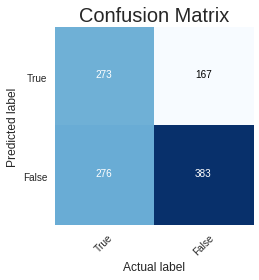

In [94]:
confusion_matrix_plot(y_test, predicted)

In [95]:
np.mean(cross_val_score(text_clf, X["tokenized"], y, n_jobs=-1, cv=10))

0.6094677987160904

In [0]:
# roc_curve_plot(y_test, predicted)

In [97]:
test_string = [rm_stop_and_tokenize("You had me at hello.")]
print(test_string)
text_clf.predict(test_string)

['you had me at hello']


array([1])

GridSearchCV MultinomialNB

In [98]:
parameters = {
    # "vect__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "vect__max_features": [1000, 2000, 3000, None],
    # "tfidf__use_idf": (True, False),
    "clf__alpha": (1e-0, 1e-1, 1e-2, 1e-3),
    }
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train["tokenized"], y_train)
gs_clf.best_params_

{'clf__alpha': 1.0, 'vect__max_features': None}

In [99]:
gs_clf.best_score_

0.593019726858877

In [100]:
predicted = gs_clf.predict(X_test["tokenized"])
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
totalpn = tn + fp + fn + tp
cf_mx = np.array([[tp/totalpn, fp/totalpn],[fn/totalpn, tn/totalpn]])
cf_mx

array([[0.24840764, 0.15195632],
       [0.2511374 , 0.34849864]])

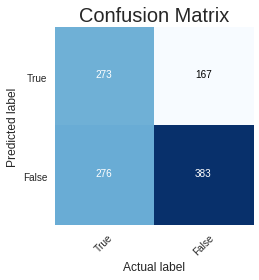

In [101]:
confusion_matrix_plot(y_test, predicted)

In [102]:
%%time
# np.mean(cross_val_score(gs_clf, X["tokenized"], y, n_jobs=-2, cv=10))

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.6 µs


In [0]:
# roc_curve_plot(y_test, predicted)

In [104]:
test_string = [rm_stop_and_tokenize("You had me at hello.")]
print(test_string)
gs_clf.predict(test_string)

['you had me at hello']


array([1])

SGDClassifier

In [105]:
text_clf_sgd = Pipeline([
                         ("vect", CountVectorizer(ngram_range=(1,3))),
                         ("tfidf", TfidfTransformer()),
                         ("clf-sgd", SGDClassifier(n_jobs=-1)),
                         ])
text_clf_sgd.fit(X_train["tokenized"], y_train)
print(text_clf_sgd.score(X_test["tokenized"], y_test))

predicted = text_clf_sgd.predict(X_test["tokenized"])
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
totalpn = tn + fp + fn + tp
cf_mx = np.array([[tp/totalpn, fp/totalpn],[fn/totalpn, tn/totalpn]])
cf_mx

0.6105550500454959


array([[0.26933576, 0.15923567],
       [0.23020928, 0.34121929]])

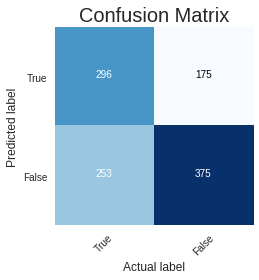

In [106]:
confusion_matrix_plot(y_test, predicted)

In [107]:
np.mean(cross_val_score(text_clf_sgd, X["tokenized"], y, n_jobs=-1, cv=10))

0.6071986953820667

In [0]:
# roc_curve_plot(y_test, predicted)

In [109]:
test_string = [rm_stop_and_tokenize("You had me at hello.")]
print(test_string)
text_clf_sgd.predict(test_string)

['you had me at hello']


array([1])

GridSearchCV SGDClassifier

In [110]:
parameters = {
    # "clf-sgd__loss": ("hinge", "log", "modified_huber"),
    # "clf-sgd__penalty": ("l2", "l1", "elasticnet"),
    "clf-sgd__alpha": (1e-2, 1e-3, 1e-4, 1e-5),
    }
gs_clf_sgd = GridSearchCV(text_clf_sgd, parameters, n_jobs=-1)
gs_clf_sgd = gs_clf_sgd.fit(X_train["tokenized"], y_train)
gs_clf_sgd.best_params_

{'clf-sgd__alpha': 0.001}

In [111]:
gs_clf_sgd.best_score_

0.607587253414264

In [112]:
np.mean(cross_val_score(gs_clf_sgd, X["tokenized"], y, n_jobs=-2, cv=10))

0.6117513978049286

In [113]:
predicted = gs_clf_sgd.predict(X_test["tokenized"])
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
totalpn = tn + fp + fn + tp
cf_mx = np.array([[tp/totalpn, fp/totalpn],[fn/totalpn, tn/totalpn]])
cf_mx

array([[0.27752502, 0.16287534],
       [0.22202002, 0.33757962]])

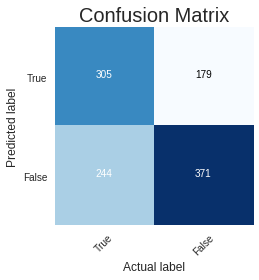

In [114]:
confusion_matrix_plot(y_test, predicted)

In [0]:
# roc_curve_plot(y_test, predicted)

In [116]:
test_string = [rm_stop_and_tokenize('You had me at "Hello."')]
print(test_string)
gs_clf_sgd.predict(test_string)

['you had me at hello']


array([1])

In [0]:
# with open("gs_clf_sgd.pkl", "wb") as f:
#     pickle.dump(gs_clf_sgd, f)

BernoulliNB

In [118]:
text_clf_bern = Pipeline([
                     ("vect", CountVectorizer(ngram_range=(1,3))),
                     ("tfidf", TfidfTransformer()),
                     ("clf", BernoulliNB()),
                     ])
text_clf_bern = text_clf_bern.fit(X_train["tokenized"], y_train)
print(text_clf_bern.score(X_test["tokenized"], y_test))

predicted = text_clf_bern.predict(X_test["tokenized"])
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
totalpn = tn + fp + fn + tp
cf_mx = np.array([[tp/totalpn, fp/totalpn],[fn/totalpn, tn/totalpn]])
cf_mx

0.5959963603275705


array([[0.2766151 , 0.1810737 ],
       [0.22292994, 0.31938126]])

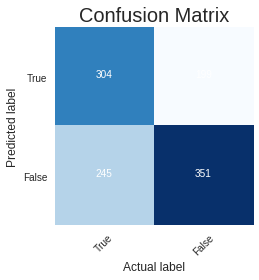

In [119]:
confusion_matrix_plot(y_test, predicted)

In [120]:
np.mean(cross_val_score(text_clf_bern, X["tokenized"], y, n_jobs=-1, cv=10))

0.6044626216607993

In [0]:
# roc_curve_plot(y_test, predicted)

In [122]:
test_string = [rm_stop_and_tokenize("You had me at hello.")]
print(test_string)
text_clf_bern.predict(test_string)

['you had me at hello']


array([1])

RandomForestClassifier

In [123]:
text_clf_rfc = Pipeline([
                    ("vect", CountVectorizer(ngram_range=(1,3))),
                    ("tfidf", TfidfTransformer()),
                    ("clf", RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1)),
                    ])
text_clf_rfc = text_clf_rfc.fit(X_train["tokenized"], y_train)
print(text_clf_rfc.score(X_test["tokenized"], y_test))

predicted = text_clf_rfc.predict(X_test["tokenized"])
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
totalpn = tn + fp + fn + tp
cf_mx = np.array([[tp/totalpn, fp/totalpn],[fn/totalpn, tn/totalpn]])
cf_mx

0.5941765241128298


array([[0.17925387, 0.0855323 ],
       [0.32029117, 0.41492266]])

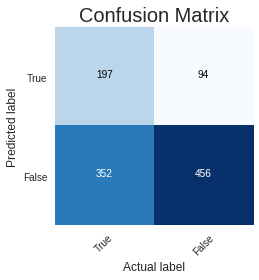

In [124]:
confusion_matrix_plot(y_test, predicted)

In [125]:
np.mean(cross_val_score(text_clf_rfc, X["tokenized"], y, n_jobs=-1, cv=10))

0.5817032511907226

In [0]:
# roc_curve_plot(y_test, predicted)

In [127]:
test_string = [rm_stop_and_tokenize("You had me at hello.")]
print(test_string)
text_clf_rfc.predict(test_string)

['you had me at hello']


array([0])

CatBoostClassifier

In [128]:
text_clf_cat = Pipeline([
                    ("vect", CountVectorizer(ngram_range=(1,3))),
                    ("tfidf", TfidfTransformer()),
                    ("clf", CatBoostClassifier(verbose=False)),
                    ])
text_clf_cat = text_clf_cat.fit(X_train["tokenized"], y_train)
predicted = text_clf_cat.predict(X_test["tokenized"])

np.mean(y_test == predicted)

0.5796178343949044

In [129]:
%%time
# np.mean(cross_val_score(text_clf_cat, X["tokenized"], y, n_jobs=-2, cv=10))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


In [0]:
# roc_curve_plot(y_test, predicted)

In [131]:
test_string = [rm_stop_and_tokenize("You had me at hello.")]
print(test_string)
text_clf_cat.predict(test_string)

['you had me at hello']


array([1])

LinearSVC

In [132]:
text_clf_lsvc = Pipeline([
                    ("vect", CountVectorizer(ngram_range=(1,3))),
                    ("tfidf", TfidfTransformer()),
                    ("clf", LinearSVC()),
                    ])
text_clf_lsvc = text_clf_lsvc.fit(X_train["tokenized"], y_train)
print(text_clf_lsvc.score(X_test["tokenized"], y_test))

predicted = text_clf_lsvc.predict(X_test["tokenized"])
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
totalpn = tn + fp + fn + tp
cf_mx = np.array([[tp/totalpn, fp/totalpn],[fn/totalpn, tn/totalpn]])
cf_mx

0.6141947224749773


array([[0.26842584, 0.15468608],
       [0.2311192 , 0.34576888]])

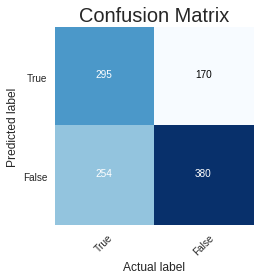

In [133]:
confusion_matrix_plot(y_test, predicted)

In [134]:
np.mean(cross_val_score(text_clf_lsvc, X["tokenized"], y, n_jobs=-1, cv=10))

0.611518948022365

In [0]:
# roc_curve_plot(y_test, predicted)

In [136]:
test_string = [rm_stop_and_tokenize("You had me at hello.")]
print(test_string)
text_clf_lsvc.predict(test_string)[0]

['you had me at hello']


1

In [0]:
# with open("text_clf_lsvc.pkl", "wb") as f:
#     pickle.dump(text_clf_lsvc, f)

In [0]:
def is_this_memorable(x, model="sgd", return_bool=False):
  """
  x : string
  model : trained classifier
    sgd or svc
  """
  from nltk.corpus import stopwords
  from nltk.stem import WordNetLemmatizer
  import re
  from nltk.tokenize import word_tokenize
  import random

  stop_words = set(stopwords.words("english"))

  def rm_stop_and_tokenize(x, join=True, remove_stop=False):
    x = re.sub('\W+', ' ', x)
    wnl = WordNetLemmatizer()
    if remove_stop:
      string = " ".join([wnl.lemmatize(word).lower() for word in x.split() if word.lower() not in stop_words])
    else:
      string = " ".join([wnl.lemmatize(word).lower() for word in x.split()])
    tokens = word_tokenize(string)
    if join:
      return " ".join(tokens)
    return tokens



  x = [rm_stop_and_tokenize(x)]
  models = {"sgd": gs_clf_sgd, "svc": text_clf_lsvc}
  memorable = models[model].predict(x)
  if return_bool:
    return memorable[0]
  if memorable:
    return random.sample(["It is certain.",
            "It is decidedly so.",
            "Without a doubt.",
            "Yes - definitely.",
            "You may rely on it.",
            "As I see it, yes.",
            "Most likely.",
            "Outlook good.",
            "Yes.",
            "Signs point to yes."], 1)[0]
  else:
    return random.sample(["Don't count on it.",
                          "My reply is no.",
                          "My sources say no.",
                          "Outlook not so good.",
                          "Very doubtful."], 1)[0]

In [0]:
# with open("is_this_memorable.pkl", "wb") as f:
#     pickle.dump(is_this_memorable, f)

Clustering

In [0]:
# for n_clusters in range(2,10):
#   text_clstr = Pipeline([
#                       ("vect", CountVectorizer(ngram_range=(1,3))),
#                       ("tfidf", TfidfTransformer()),
#                       ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), 
#                       ("clstr", KMeans(n_clusters=n_clusters, n_jobs=-1)),
#                       ])
#   text_clstr = text_clstr.fit(df[df["memorable?"] == 1]["tokenized"])
#   cluster_labels = text_clstr["clstr"].fit_predict(text_clstr["tfidf"].idf_.reshape(-1, 1))
#   print(n_clusters)
#   print(silhouette_score(text_clstr["tfidf"].idf_.reshape(-1, 1), cluster_labels))

In [141]:
%%time

X_feats = Pipeline([
                    ("vect", CountVectorizer(ngram_range=(1,3))),
                    ("tfidf", TfidfTransformer()),
                    ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                    ])
X_feats = X_feats.fit_transform(df["line"])

range_n_clusters = range(2,9)
for n_clusters in range_n_clusters:
  mbkmeans = MiniBatchKMeans(n_clusters=n_clusters)
  cluster_labels = mbkmeans.fit_predict(X_feats)

  silhouette_avg = silhouette_score(X_feats, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)


For n_clusters = 2 The average silhouette_score is : 0.000551553181869346
For n_clusters = 3 The average silhouette_score is : 0.0006962949895772389
For n_clusters = 4 The average silhouette_score is : -8.999853352699095e-05
For n_clusters = 5 The average silhouette_score is : -0.0010985983681803797
For n_clusters = 6 The average silhouette_score is : -0.0014819638168869387
For n_clusters = 7 The average silhouette_score is : -0.0021175095540299574
For n_clusters = 8 The average silhouette_score is : -0.0031349801927636795
CPU times: user 8min 5s, sys: 58.5 s, total: 9min 3s
Wall time: 4min 39s


In [0]:
mini_km = MiniBatchKMeans(n_clusters=2).fit(X_feats)

In [0]:
euc_arr0 = []
euc_arr1 = []
for row in X_feats:
  euc_arr0.append(distance.euclidean(row, mini_km.cluster_centers_[0]))
  euc_arr1.append(distance.euclidean(row, mini_km.cluster_centers_[1]))
euc_arr0 = np.array(euc_arr0)
euc_arr1 = np.array(euc_arr1)

In [0]:
# cos_arr0 = []
# cos_arr1 = []
# for row in array_text:
#   cos_arr0.append(distance.cosine(row, mini_km.cluster_centers_[0]))
#   cos_arr1.append(distance.cosine(row, mini_km.cluster_centers_[1]))
# cos_arr0 = np.array(cos_arr0)
# cos_arr1 = np.array(cos_arr1)

In [145]:
Counter(mini_km.labels_)

Counter({0: 35, 1: 4359})

In [146]:
euc_arr0.argsort()

array([1726, 3400,  823, ...,  806, 3444, 2780])

In [147]:
euc_arr1.argsort()

array([3681, 3135, 3079, ...,  589,  688, 2120])

In [148]:
np.sum(X_feats[2262])

2.449489742783178

In [149]:
rm_stop_and_tokenize("I despise a floggin' rooster.	")

'i despise a floggin rooster'

In [150]:
df.iloc[euc_arr0.argsort()[:10]]

,movie_title,line,levenshtein_distance_from_script,memorable?,tokenized,parts_of_speech
line_id,,,,,,
133341,the boondock saints,So you're telling me it was one guy with six g...,7,1,so you re telling me it wa one guy with six gu...,"[RB, JJ, VBG, PRP, PRP, VBD, CD, NN, IN, CD, N..."
816815,tombstone,Forgive me if I don't shake hands.,0,1,forgive me if i don t shake hand,"[CD, PRP, IN, PRP, VBP, VB, NN]"
10197,a nightmare on elm street 3: dream warriors,NOBODY'S GONNA PUT ME TO SLEEP!,0,0,nobody s gon na put me to sleep,"[NNP, NNP, NNP, NNP, NNP, NNP]"
773856,terminator,Come with me if you want to live.,0,1,come with me if you want to live,"[VBN, IN, PRP, IN, PRP, VBP, TO, VB]"
774531,terminator 2: judgment day,Come with me if you want to live!,1,1,come with me if you want to live,"[VBN, IN, PRP, IN, PRP, VBP, TO, VB]"
401900,the incredibles,You're not affiliated with me!,56,1,you re not affiliated with me,"[NNP, RB, VBD, IN, NN]"
731932,star trek nemesis,"Data, Worf, you're with me.",0,0,data worf you re with me,"[NNP, NNP, NN, IN, NN]"
616513,the princess bride,"-- pardon me, it's important --",0,0,pardon me it s important,"[:, NN, NN, NN, JJ, :]"
792365,the producers,"It's only two thousand dollars, Bloom, do me a...",0,0,it s only two thousand dollar bloom do me a fa...,"[NNP, RB, CD, VBP, NNS, NNP, VBP, PRP, DT, JJ,..."


In [151]:
df.iloc[euc_arr1.argsort()[:10]]

,movie_title,line,levenshtein_distance_from_script,memorable?,tokenized,parts_of_speech
line_id,,,,,,
645373,revolutionary road,And what do you think you're going to do?,0,0,and what do you think you re going to do,"[CC, WP, VBP, PRP, VB, RB, VBG, TO, VB]"
698263,the sixth sense,You don't have to tell me your secret if you d...,0,0,you don t have to tell me your secret if you d...,"[PRP, VBP, VB, TO, VB, PRP, PRP$, JJ, IN, PRP,..."
683835,shallow grave,"You're not going to take it to a bank Or what,...",0,0,you re not going to take it to a bank or what ...,"[MD, RB, VBG, TO, VB, PRP, TO, DT, NN, CC, VB,..."
233874,dogma,...and now you're telling me that I'm supposed...,0,0,and now you re telling me that i m supposed to...,"[NN, RB, VBZ, VBG, PRP, IN, NNP, VBD, TO, VB, ..."
545759,mumford,I agree with you that you don't know what you'...,0,0,i agree with you that you don t know what you ...,"[PRP, VBP, IN, PRP, IN, PRP, VBP, VB, WP, VB, ..."
694505,silence of the lambs,You're so close to the way you're going to cat...,0,0,you re so close to the way you re going to cat...,"[NNP, RB, RB, TO, DT, NN, VBZ, VBG, TO, VB, PR..."
411547,interview with the vampire: the vampire chroni...,So you want me to tell you the story of my life?,3,1,so you want me to tell you the story of my life,"[RB, PRP, VBP, PRP, TO, VB, PRP, DT, NN, IN, P..."
83548,backdraft,Do you have to do that?,0,0,do you have to do that,"[VBP, PRP, VB, TO, VB, VB]"
644959,revolutionary road,Just because you've got me safe in this little...,13,1,just because you ve got me safe in this little...,"[RB, IN, NN, VBD, PRP, JJ, IN, DT, JJ, NN, PRP..."


In [0]:
# cluster_labels = text_clstr["clstr"].fit_predict(text_clstr["tfidf"].idf_.reshape(-1, 1))

# silhouette_score(text_clstr["tfidf"].idf_.reshape(-1, 1), cluster_labels)

In [0]:
# text = Pipeline([
#                  ("vect", CountVectorizer(ngram_range=(1,3))),
#                  ("tfidf", TfidfTransformer()),
#                  ])
# text_clstr = text_clstr.fit((df[df["memorable?"] == 1]["tokenized"]))

# text = text.fit_transform(df["tokenized"])
# df["tfidf"] = list(text)
# df["tfidf"] = df["tfidf"].apply(lambda x: x.toarray())

In [0]:
# df.iloc[0]["tfidf"].toarray().shape

In [0]:
#

In [156]:
vocab = set((" ".join(df["tokenized"]).split()))
len(vocab)

5636

In [157]:
class_counts = Counter(y)
class_counts

Counter({0: 2197, 1: 2197})

In [158]:
total_docs = sum(class_counts.values())
total_docs

4394

In [159]:
words_per_class = defaultdict(int)
word_count_per_class = defaultdict(Counter)

for doc, label in zip(X["tokenized"],y):
    words_per_class[label] += len(doc.split())
    word_count_per_class[label].update(Counter(doc.split()))

words_per_class

defaultdict(int, {0: 22569, 1: 22565})